In [63]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pdb import set_trace
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
if "hh_combination_fw_path" not in os.environ:
    os.environ['hh_combination_fw_path'] = os.path.abspath("../../")
outdir_xsection = os.environ['hh_combination_fw_path']+'/output_HHH_20220415_noSgHparam/'
outdir_likelihood = os.environ['hh_combination_fw_path']+'/output_HHH_20220415/'

# plotdir = os.environ['hh_combination_fw_path']+'/output_HHH3/figures'
# os.makedirs(plotdir, exist_ok=True)

In [65]:
channels = ['bbtautau', 'bbyy', 'bbbb']
resonant_type = 'nonres'
combine_tag = 'A-bbtautau_bbyy-fullcorr'

In [66]:
def remove_list(data):
    for k, v in data.items():
        for p,v_ in v.items():
            data[k][p] = v_[0]
    return data


def get_xsection_data(study):
    data = {}
    for channel in channels+['combined']:
        limit_path = os.path.join(outdir_xsection, study, channel, 'limits.json')
        data[channel] = json.load(open(limit_path))
    return data


In [67]:
channel_label_map = {
    'bbbb': r"$\mathrm{b\bar{b}b\bar{b}}$",
    'bbtautau': r"$\mathrm{b\bar{b}\tau^+\tau^-}$",
    'bbyy': r"$\mathrm{b\bar{b}\gamma\gamma}$",
    'combined': r"Combined",
}
channel_text = {
    'combined': r'$\mathrm{HH\rightarrow b\bar{b}\tau^+\tau^-} + b\bar{b}\gamma\gamma + b\bar{b}b\bar{b}$',
    'bbbb': r'$\mathrm{HH\rightarrow b\bar{b}b\bar{b}}$',
    'bbyy': r'$\mathrm{HH\rightarrow b\bar{b}\gamma\gamma}$',
    'bbtautau': r'$\mathrm{HH\rightarrow b\bar{b}\tau^+\tau^-}$',
}   


## 1. SM Limit Plot

### 1.1 Data Loading

In [68]:
# scale_factor = 1000/32.776
# sm_limit_df = {}
# channels = ['bbtautau', 'bbyy']
# data = get_limit_data(scenario, 'SM_out', True)
# data_dict = remove_list(data)
# sm_limit_df = pd.DataFrame(data_dict) * scale_factor

### 1.2 Plotting

In [69]:
# from quickstats.plots import UpperLimit1DPlot

In [70]:
# plotting_order = ['combined', 'bbyy', 'bbtautau']
# sm_limit_df = sm_limit_df[plotting_order]

In [71]:
# analysis_label_options = {'fontsize':30, 'energy': '13 TeV', 
#                                   'lumi': '139 fb$^{-1}$',
#                                   'extra_text': r'$\sigma_{ggF+VBF}^{SM}=32.78$ fb',
#                                   }
# styles = {
#             'axis':{
#                 'tick_bothsides': False,
#                 'major_length': 12,
#                 },
#             'legend':{
#                 'loc': 'upper right',
#                 },
#             'figure':{
#                 'figsize': (15,13),
#                 }
#         }
                     
# plotter = UpperLimit1DPlot(sm_limit_df, channel_label_map, line_below=["bbyy"],
#                            analysis_label_options=analysis_label_options, styles=styles)
# ax = plotter.draw(logx=True, xlabel=r"95% CL upper limit on signal strength", draw_observed=True, draw_stat=False)
# # ax.set_xlim([0, None])
# ax.set_xlim([1, 80])

# plt.savefig(plotdir+f"/plots/SM_limit.pdf", bbox_inches="tight")

## 2. Cross section Scan

In [72]:
import math
#Now using values from LHCWHGHHHXGGBGGGXXX
SCALE_GGF = 31.05/31.0358 #31.02/31.0358   #correct to xs at mH = 125.09 
SCALE_VBF = 1.726/(4.581-4.245+1.359) # 1.723/(4.581-4.245+1.359)

def xs_ggF(kl):
    #https://twiki.cern.ch/twiki/bin/view/LHCPhysics/LHCHWGHH?redirectedfrom=LHCPhysics.LHCHXSWGHH#Latest_recommendations_for_gluon
    return (70.3874-50.4111*kl+11.0595*kl**2)*SCALE_GGF #XS in fb

def xs_VBF(kl):
    #https://indico.cern.ch/event/995807/contributions/4184798/attachments/2175756/3683303/VBFXSec.pdf
    return (4.581-4.245*kl+1.359*kl**2)*SCALE_VBF

def xs_HH(kl, s=13):
    if s == 13:
        return xs_ggF(kl) + xs_VBF(kl)
    elif s == 14:
        return xs_ggF(kl)*1.18 + xs_VBF(kl) * 1.19

# When adding 2 independent Gaussians (e.g. ggF and VBF XS) we can simply add their means and add their sigmas in quadrature
def sigma_upper_ggF(kl):
    #https://twiki.cern.ch/twiki/bin/view/LHCPhysics/LHCHWGHH?redirectedfrom=LHCPhysics.LHCHXSWGHH#Latest_recommendations_for_gluon
    #add the std on ggF HH due to qcd scale, PDF, and mtop in quadrature
    #return xs_ggF(kl) * math.sqrt((max(72.0744-51.7362*kl+11.3712*kl**2, 70.9286-51.5708*kl+11.4497*kl**2) * SCALE_GGF / xs_ggF(kl) - 1)**2 + 0.03**2 + 0.026**2)
    #new mtop uncertainty:
    return xs_ggF(kl) * math.sqrt((max(76.6075 - 56.4818*kl + 12.635*kl**2, 75.4617 - 56.3164*kl + 12.7135*kl**2) * SCALE_GGF / xs_ggF(kl) - 1)**2 + 0.03**2)

def sigma_upper_VBF(kl):
    #from klambda = 1
    return xs_VBF(kl) * math.sqrt(0.0003**2 + 0.021**2)

def sigma_upper_HH(kl, s=13):
    error = math.sqrt(sigma_upper_ggF(kl)**2 + sigma_upper_VBF(kl)**2)
    if s == 14:
        error /= 2
    return error

def xs_upper_HH(kl, s=13):
    return xs_HH(kl, s) + sigma_upper_HH(kl, s)

def sigma_lower_ggF(kl):
    #https://twiki.cern.ch/twiki/bin/view/LHCPhysics/LHCHWGHH?redirectedfrom=LHCPhysics.LHCHXSWGHH#Latest_recommendations_for_gluon
    #add the std on ggF HH due to qcd scale, PDF, and mtop in quadrature
    #return xs_ggF(kl) * math.sqrt((min(66.0621-46.7458*kl+10.1673*kl**2, 66.7581-47.721*kl+10.4535*kl**2) * SCALE_GGF / xs_ggF(kl) - 1)**2 + 0.03**2 + 0.026**2)
    #new mtop uncertainty:
    return xs_ggF(kl) * math.sqrt((min(57.6809 - 42.9905*kl + 9.58474*kl**2, 58.3769 - 43.9657*kl + 9.87094*kl**2) * SCALE_GGF / xs_ggF(kl) - 1)**2 + 0.03**2)

def sigma_lower_VBF(kl):
    return xs_VBF(kl) * math.sqrt(0.0004**2 + 0.021**2)

def sigma_lower_HH(kl, s):
    error = math.sqrt(sigma_lower_ggF(kl)**2 + sigma_lower_VBF(kl)**2)
    if s == 14:
        error /= 2
    return error
    
def xs_lower_HH(kl, s=13):
    return xs_HH(kl, s) - sigma_lower_HH(kl, s)


def get_intersections(lambdas, n_exp, lambdas_th, n_th):
    # get the intersection between expected and theory prediction
    
    # interpolate expected limit with same number of datapoints as used in theory prediction
    interpolated_limit = np.interp(lambdas_th, lambdas, n_exp) 

    #limitm1 = n*np.array(limit_bands[0]) - 1
    limitm1 = interpolated_limit - n_th 
    idx = np.argwhere(np.diff(np.sign(limitm1))).flatten() # determines what index intersection points are at 

    #linear interpolation to get exact intercepts: x = x1 + (x2-x1)/(y2-y1) * (y-y1)
    #y = 0 -> x = x1 - (x2-x1)/(y2-y1) * y1
    intersections = [lambdas_th[x] - (lambdas_th[x+1] - lambdas_th[x])/(limitm1[x+1] - limitm1[x]) * limitm1[x] for x in idx]
    return intersections

### 2.1 Load Parameterised workspace limits

In [73]:
kl_param_limit_df  = {}

kl_param_limit_df = {}
data = get_xsection_data('xsection_scan/')
for channel in data:
    df = pd.DataFrame(data[channel]).set_index(['klambda'])
    kl_param_limit_df[channel] = df

# kl_param_limit_df['bbyy']['obs'].to_numpy()
kl_param_limit_df.keys()


dict_keys(['bbtautau', 'bbyy', 'bbbb', 'combined'])

### 2.2 Plotting

In [74]:
from quickstats.plots import UpperLimit2DPlot

In [75]:
sE=13 # 13 TeV
klambda_values = kl_param_limit_df['bbbb'].index.astype(float).values
scale_factor = np.array([xs_HH(kl, s=sE) for kl in klambda_values])

klambda_theory_values = np.linspace(min(klambda_values), max(klambda_values), 1000) 
theory_xs_values = np.array([xs_HH(kl, s=sE) for kl in klambda_theory_values])
theory_xs_lower = np.array([xs_lower_HH(kl, s=sE) for kl in klambda_theory_values])
theory_xs_upper = np.array([xs_upper_HH(kl, s=sE) for kl in klambda_theory_values])

In [76]:
def plot_xsection_scan(channel):

    analysis_label_options = {
        'loc': (0.05, 0.95),
        'energy': '13 TeV',
        'lumi': r'139 fb$^{-1}$',
        'fontsize': 30,
        'extra_text':channel_text[channel] # + '//Parameterised workspace'    
    }
    styles = {
        'legend':{
            'loc': (0.58, 0.63),
            'fontsize': 17
        }
    }

    plotter = UpperLimit2DPlot(kl_param_limit_df[channel], 
                               scale_factor=scale_factor, styles=styles,
                               analysis_label_options=analysis_label_options)
    plotter.add_curve(klambda_theory_values, theory_xs_values, theory_xs_lower, theory_xs_upper, 
                      label="Theory prediction")
    plotter.add_highlight(1, xs_HH(1, s=sE),
                          label="SM prediction")
    ax = plotter.draw(xlabel=r"$\mathrm{\kappa_{\lambda}}$", ylabel=r"$\sigma_{ggF+VBF}(HH) [fb]$",
                 draw_observed=True, log=True, ylim=[10, 1e5], xlim=[-6,11], observed_marker='')
    intersections = get_intersections(klambda_values, 
                                      scale_factor*kl_param_limit_df[channel]['0'],
                                      klambda_theory_values, theory_xs_values)

    intersections_obs = get_intersections(klambda_values, 
                                      scale_factor*kl_param_limit_df[channel]['obs'],
                                      klambda_theory_values, theory_xs_values)
    ax.annotate(r'Expected: $\kappa_\lambda \in [%.1f, %.1f]$' %(intersections[0], intersections[1]), 
                (0.05, 0.08), xycoords = 'axes fraction', fontsize = 18)
    ax.annotate(r'Observed: $\kappa_\lambda \in [%.1f, %.1f]$' %(intersections_obs[0], intersections_obs[1]), 
                (0.05, 0.15), xycoords = 'axes fraction', fontsize = 18)
    print(channel, 'obs', intersections_obs[0], intersections_obs[1])
    print(channel, 'exp', intersections[0], intersections[1])
    
    # Add individual curves on top
    if channel == 'combined':
        pass

    save_foler = outdir_xsection+"/figures/xsection_scan/"
    os.makedirs(save_foler, exist_ok=True)
    plt.savefig(save_foler+f"kl_limit_parameterised_ws_{channel}.pdf", bbox_inches="tight")
    print("save to", save_foler)


In [77]:
# ##############
# ## Cross section scan ###
# ###########

# !quickstats limit_scan -i /afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/output_HHH_20220415_noSgHparam/rescaled/nonres/bbyy/0_kl.root --outdir /afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/output_HHH_20220415_noSgHparam/xsection_scan/bbyy --param_expr "klambda=-6_12_0.2" -p xsec_br --unblind --fix "THEO_XS_fixmu_*=0,alpha_THEO_XS_PDFalphas_VBFSMHH*=0,alpha_THEO_XS_PDFalphas_ggFSMHH*=0,alpha_THEO_XS_SCALEMTop_ggFSMHH*=0,THEO_XS_COMBINED_HH_ggF*=0,THEO_XS_PDFalphas_HH_VBF*=0,THEO_XS_PDFalphas_HH_ggF*=0,THEO_XS_SCALE_HH_VBF*=0"

# !quickstats limit_scan -i /afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/output_HHH_20220415_noSgHparam/combined/nonres/A-bbbb_bbtautau_bbyy-fullcorr/0_kl.root --outdir /afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/output_HHH_20220415_noSgHparam/xsection_scan/combined --param_expr "klambda=-6_12_0.2" -p xsec_br --unblind --fix "THEO_XS_fixmu_*=0,alpha_THEO_XS_PDFalphas_VBFSMHH*=0,alpha_THEO_XS_PDFalphas_ggFSMHH*=0,alpha_THEO_XS_SCALEMTop_ggFSMHH*=0,THEO_XS_COMBINED_HH_ggF*=0,THEO_XS_PDFalphas_HH_VBF*=0,THEO_XS_PDFalphas_HH_ggF*=0,THEO_XS_SCALE_HH_VBF*=0"

# !quickstats limit_scan -i /afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/output_HHH_20220415_noSgHparam/rescaled/nonres/bbtautau/0_kl.root --outdir /afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/output_HHH_20220415_noSgHparam/xsection_scan/bbtautau --param_expr "klambda=-6_12_0.2" -p xsec_br --unblind --fix "THEO_XS_fixmu_*=0,alpha_THEO_XS_PDFalphas_VBFSMHH*=0,alpha_THEO_XS_PDFalphas_ggFSMHH*=0,alpha_THEO_XS_SCALEMTop_ggFSMHH*=0,THEO_XS_COMBINED_HH_ggF*=0,THEO_XS_PDFalphas_HH_VBF*=0,THEO_XS_PDFalphas_HH_ggF*=0,THEO_XS_SCALE_HH_VBF*=0"

# !quickstats limit_scan -i /afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/output_HHH_20220415_noSgHparam/rescaled/nonres/bbbb/0_kl.root --outdir /afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/output_HHH_20220415_noSgHparam/xsection_scan/bbbb --param_expr "klambda=-6_12_0.2" -p xsec_br --unblind --fix "THEO_XS_fixmu_*=0,alpha_THEO_XS_PDFalphas_VBFSMHH*=0,alpha_THEO_XS_PDFalphas_ggFSMHH*=0,alpha_THEO_XS_SCALEMTop_ggFSMHH*=0,THEO_XS_COMBINED_HH_ggF*=0,THEO_XS_PDFalphas_HH_VBF*=0,THEO_XS_PDFalphas_HH_ggF*=0,THEO_XS_SCALE_HH_VBF*=0"

bbbb obs -3.54514597304699 11.120725120551386
bbbb exp -4.278994161938921 10.819950987719592
save to /afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/output_HHH_20220415_noSgHparam//figures/xsection_scan/
bbtautau obs -2.43018908402639 9.346632507022889
bbtautau exp -1.9804361727406172 9.078574732522378
save to /afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/output_HHH_20220415_noSgHparam//figures/xsection_scan/
bbyy obs -1.5242428392105458 6.680912306406413
bbyy exp -2.3579031983581227 7.619111735554188
save to /afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/output_HHH_20220415_noSgHparam//figures/xsection_scan/
combined obs -0.5674954203226411 6.636424542267352
combined exp -0.9598173150894077 7.075232701993098
save to /afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/output_HHH_20220415_noSgHparam//figures/xsection_scan/


<Figure size 432x288 with 0 Axes>

<Figure size 799.992x599.976 with 0 Axes>

<Figure size 799.992x599.976 with 0 Axes>

<Figure size 799.992x599.976 with 0 Axes>

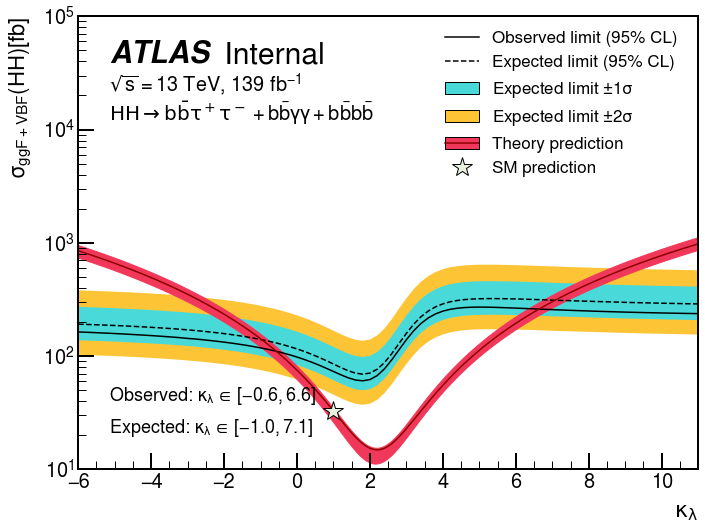

In [78]:
plot_xsection_scan('bbbb')
plot_xsection_scan('bbtautau')
plot_xsection_scan('bbyy')
plot_xsection_scan('combined')


## 3. Likelihood Scan

In [79]:
def get_likelihood_data(obs, study):
    data = {}
    filename = {
        '1D_kt_nominal': 'klambda.json',
        '1D_kt_profiled': 'klambda_kt.json',
        '2D_kl_kt': 'klambda_kt.json',
    }
    for channel in channels+['combined']:
        limit_path = os.path.join(outdir_likelihood, 'likelihood_scan', obs, channel, study, filename[study])
        data[channel] = json.load(open(limit_path))
    return data

def get_uncond_data(obs, study):
    data = {}
    filename = {
        '1D_kt_nominal': 'klambda_uncond.json',
        '1D_kt_profiled': 'klambda_kt_uncond.json',
        '2D_kl_kt': 'klambda_kt_uncond.json',
    }
    for channel in channels+['combined']:
        limit_path = os.path.join(outdir_likelihood, 'likelihood_scan', obs, channel, study, 'cache', filename[study])
        data[channel] = json.load(open(limit_path))
    return data
    
def data_loading_lh(obs, study, drop_bestfit=False, sort=True):
    likelihood_df, uncond_df = {}, {}
    data = get_likelihood_data(obs, study)
    data2 = get_uncond_data(obs, study)
    for channel in data:
        df = pd.DataFrame(data[channel]).dropna(axis=1, how='all')
        if drop_bestfit:
            df.drop(index=df.index[0], axis=0, inplace=True)
        if 'klambda' not in df:
            df.rename(columns = {'mu':'klambda'}, inplace = True)
        if sort:
            df = df.sort_values(by=['klambda'])
        likelihood_df[channel] = df
        if '2D' in study:
            uncond_df[channel] = pd.DataFrame(data2[channel]['uncond_fit'])
        else:
            uncond_df[channel] = data2[channel]['uncond_fit']
    return likelihood_df, uncond_df

In [80]:
from quickstats.plots import Likelihood1DPlot
from quickstats.plots.color_schemes import QUICKSTATS_PALETTES
color_pallete = QUICKSTATS_PALETTES['default']
from scipy.interpolate import interp1d
def get_interval(df, level):
    xvalues = df['klambda'].to_numpy()
    yvalues = df['qmu'].to_numpy()
    func_theory = interp1d(xvalues, yvalues)
    x_new = np.arange(min(xvalues), max(xvalues), 0.01)
    y_new = func_theory(x_new)
    
    asign = np.sign(y_new-level)
    signchange = ((np.roll(asign, 1) - asign) != 0).astype(int)
    intersections = x_new[signchange==1]
    if intersections[0] == xvalues.min():
        intersections[0] = -np.inf
    if intersections[-1] == xvalues.max():
        intersections[-1] = np.inf
    return intersections

In [81]:
channels = ['bbyy', 'bbtautau', 'bbbb']

studies = ['1D_kt_nominal', '1D_kt_profiled', '2D_kl_kt']
obs = ['obs', 'prefit', 'postfit2']
# studies = ['1D_kt_profiled']
# obs = ['postfit1']
likelihood_df, uncond_df = {}, {}
for o in obs:
    for study in studies:
        likelihood_df[f'{study}_{o}'], uncond_df[f'{study}_{o}'] = data_loading_lh(o, study, drop_bestfit=('2D' in study))

likelihood_df.keys()

FileNotFoundError: [Errno 2] No such file or directory: '/afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/output_HHH_20220415/likelihood_scan/obs/bbyy/1D_kt_profiled/klambda_kt.json'

In [ ]:
likelihood_df['1D_kt_nominal_obs']['bbyy']

#### Convert to google sheet

In [ ]:
# google_likelihood_df, google_uncond_df = {}, {}
# for o in ['postfit2']:
#     for study in ['1D_kt_nominal', '1D_kt_profiled']:
#         google_likelihood_df[f'google_{study}_{o}'], google_uncond_df[f'google_{study}_{o}'] = data_loading_lh(o, study, drop_bestfit=True)


# for k in google_likelihood_df:
#     for channel in google_likelihood_df[k]:
#         df_no_bestfit = google_likelihood_df[k][channel]
# #         print(df_no_bestfit)
#         val_str = ",".join([f"{v}" for v in df_no_bestfit['qmu'].values])
#         print(k, channel)
#         print(val_str)
#         print()

In [ ]:
# for k in google_uncond_df:
#     for channel in google_uncond_df[k]:
#         print(k, channel)
#         print(google_uncond_df[k][channel]['muhat']['klambda'])

### 3.1 1D klambda

In [ ]:
styles_map = {
    'bbbb': {"color": color_pallete[4], "marker": "^"},
    'bbyy': {"color": color_pallete[1], "marker": "s"},
    'bbtautau': {"color": color_pallete[2], "marker": "v"},
    'combined': {"color": color_pallete[0], "marker": "o"},
}

styles = {
    '1D_kt_nominal': {
        'legend': {
            'loc': (0.19, 0.42)
        },
    },
    '1D_kt_profiled': {
        'legend': {
            'loc': (0.17, 0.40)
        },
    },
    '2D_kl_kt': {
        'legend': {
            'loc': (0.17, 0.42)
        },
    },
}
anno_op = {
    '1D_kt_nominal': {
        'x': 0.50,
        'y': 0.62,
        'dy': 0.065,
        'font_size': 19,
    },
    '1D_kt_profiled': {
        'x': 0.48,
        'y': 0.62,
        'dy': 0.065,
        'font_size': 19,
    },
    '2D_kl_kt': {
        'x': 0.48,
        'y': 0.62,
        'dy': 0.065,
        'font_size': 19,
    },
}

def analysis_label_options_new(study, obs, channel='combined'):
    if obs == 'obs':
        text = 'Observed'
    elif obs == 'prefit':
        text = 'Prefit Asimov'
    else:
        text = 'Postfit Asimov'
    return {
        '1D_kt_nominal': {
            'loc': (0.19, 0.96),
            'fontsize': 25, # ATLAS
            'energy': '13 TeV',
            'lumi': r'139 fb$^{-1}$',
            'extra_text': channel_text[channel] + f"//{text} data, " + r"$\kappa_{t} = 1$",
        },
        '1D_kt_profiled': {
            'loc': (0.17, 0.96),
            'fontsize': 25, # ATLAS
            'energy': '13 TeV',
            'lumi': r'139 fb$^{-1}$',
            'extra_text': channel_text[channel] + f"//{text} data, " + r"$\kappa_{t}$ profiled",
        },
        '2D_kl_kt': {
            'loc': (0.17, 0.96),
            'fontsize': 25, # ATLAS
            'energy': '13 TeV',
            'lumi': r'139 fb$^{-1}$',
            'extra_text': channel_text[channel] + f"//{text} data ",
        }
    }[study]

In [ ]:
def plot_kl(study, obs, xmin = -7, xmax = 13, ymin=0, ymax = 12, yattrib='qmu'):
    options = {}
    name = 'likelihood_scan'
    if yattrib == 'kt':
        options['ylabel'] = r"Best fit $\mathrm{\kappa_{t}}$"
        options['draw_sigma_line'] = False
        name = yattrib
    if yattrib == 'qmu' and ymax < 4:
        options['draw_sigma_line'] = False
        name += '_zoom'
    
    df_index = f'{study}_{obs}'
    plotter = Likelihood1DPlot(likelihood_df[df_index], label_map=channel_label_map, styles_map=styles_map,
                            styles=styles[study], analysis_label_options=analysis_label_options_new(study, obs))
    ax = plotter.draw(xlabel=r"$\mathrm{\kappa_{\lambda}}$", ymin=ymin, ymax=ymax, xmin=xmin, xmax=xmax, xattrib='klambda', yattrib=yattrib, **options)

    if 'combined' in likelihood_df[df_index] and yattrib=='qmu':
#         print(likelihood_df[df_index]['combined'][likelihood_df[df_index]['combined']['qmu'] <= 0])
        intersections_1 = get_interval(likelihood_df[df_index]['combined'], 1).tolist()
        intersections_2 = get_interval(likelihood_df[df_index]['combined'], 4).tolist()

        ax.annotate(r'Combined:', 
                    (anno_op[study]['x'], anno_op[study]['y']), xycoords = 'axes fraction', fontsize = anno_op[study]['font_size'])
        ax.annotate(r'$1\sigma$: $\kappa_\lambda \in [%.1f, %.1f]$' %(intersections_1[0], intersections_1[1]), 
                    (anno_op[study]['x'], anno_op[study]['y'] - anno_op[study]['dy']), xycoords = 'axes fraction', fontsize = anno_op[study]['font_size'])
        ax.annotate(r'$2\sigma$: $\kappa_\lambda \in [%.1f, %.1f]$' %(intersections_2[0], intersections_2[1]), 
                    (anno_op[study]['x'], anno_op[study]['y'] - 2 * anno_op[study]['dy']), xycoords = 'axes fraction', fontsize = anno_op[study]['font_size'])

    savefolder = outdir_likelihood + '/figures/likelihood_scan'
    os.makedirs(savefolder, exist_ok=True)
#     plt.savefig(savefolder+f"/{name}_{df_index}.pdf", bbox_inches="tight")
    print('Save', savefolder+f"/{name}_{df_index}.pdf")

In [ ]:
plot_kl('1D_kt_profiled', 'postfit2', ymax = 7, xmin=-10.5, xmax=22.5)

Save /afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/output_HHH_20220415//figures/likelihood_scan/likelihood_scan_1D_kt_nominal_obs.pdf
Save /afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/output_HHH_20220415//figures/likelihood_scan/likelihood_scan_1D_kt_profiled_obs.pdf
Save /afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/output_HHH_20220415//figures/likelihood_scan/likelihood_scan_1D_kt_nominal_prefit.pdf
Save /afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/output_HHH_20220415//figures/likelihood_scan/likelihood_scan_1D_kt_profiled_prefit.pdf
Save /afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/output_HHH_20220415//figures/likelihood_scan/likelihood_scan_1D_kt_nominal_postfit2.pdf
Save /afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/output_HHH_20220415//figures/likelihood_scan/likelihood_scan_1D_kt_profiled_postfit2.pdf


<Figure size 432x288 with 0 Axes>

<Figure size 799.992x599.976 with 0 Axes>

<Figure size 799.992x599.976 with 0 Axes>

<Figure size 799.992x599.976 with 0 Axes>

<Figure size 799.992x599.976 with 0 Axes>

<Figure size 799.992x599.976 with 0 Axes>

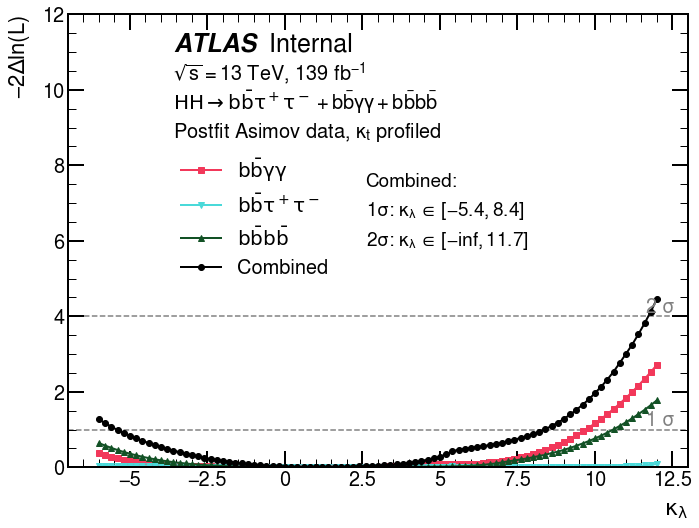

In [169]:
for o in obs:
    for study in studies:
        if '2D' in study: continue
        plot_kl(study, o)

# combined:
# 6  klambda -1.000000e+30  1.000000e+30         True           5.8       5.800000           0.0       0.000000
# 7       kt -1.000000e+30  1.000000e+30        False           1.0       0.051286           0.0       0.327024
# 6  klambda -1.000000e+30  1.000000e+30         True           5.6       5.600000           0.0        0.00000
# 7       kt -1.000000e+30  1.000000e+30        False           1.0       1.275484           0.0        0.46026

Save /afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/output_HHH_20220415//figures/likelihood_scan/kt_1D_kt_profiled_obs.pdf
Save /afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/output_HHH_20220415//figures/likelihood_scan/likelihood_scan_zoom_1D_kt_profiled_obs.pdf
Save /afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/output_HHH_20220415//figures/likelihood_scan/kt_1D_kt_profiled_prefit.pdf
Save /afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/output_HHH_20220415//figures/likelihood_scan/likelihood_scan_zoom_1D_kt_profiled_prefit.pdf
Save /afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/output_HHH_20220415//figures/likelihood_scan/kt_1D_kt_profiled_postfit2.pdf
Save /afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/output_HHH_20220415//figures/likelihood_scan/likelihood_scan_zoom_1D_kt_profiled_postfit2.pdf


<Figure size 432x288 with 0 Axes>

<Figure size 799.992x599.976 with 0 Axes>

<Figure size 799.992x599.976 with 0 Axes>

<Figure size 799.992x599.976 with 0 Axes>

<Figure size 799.992x599.976 with 0 Axes>

<Figure size 799.992x599.976 with 0 Axes>

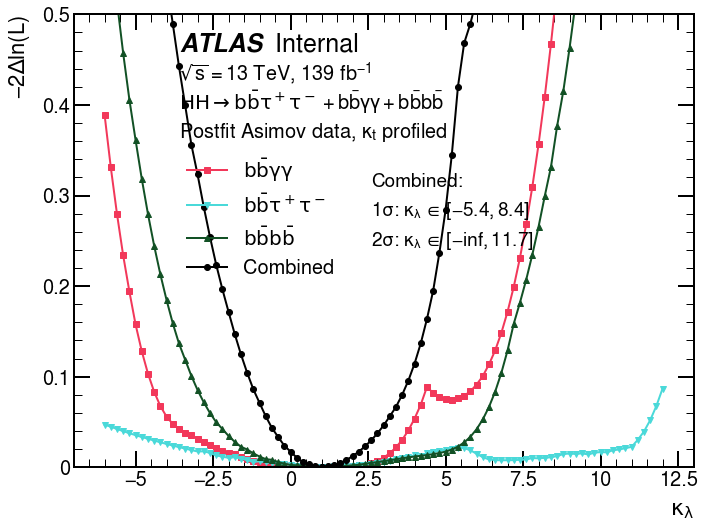

In [170]:
for o in obs:
    for study in studies:
        if 'nominal' in study or '2D' in study: continue
        plot_kl(study, o, xmin = -7, xmax = 13, ymin=-0.5, ymax = 2, yattrib='kt')
        plot_kl(study, o, ymax = 0.5)

In [163]:
df = likelihood_df['1D_kt_profiled_obs']['bbtautau']
df[(df['klambda'] > 2.5) & (df['klambda'] < 4)]

,nll,qmu,klambda,kt
44,290961.660450,0.525075,2.6,1.087218
45,290961.665171,0.534518,2.8,1.107604
46,290961.670214,0.544603,3.0,1.127314
47,290961.675644,0.555464,3.2,1.145561
48,290961.681534,0.567244,3.4,1.162914
49,290961.732625,0.669426,3.6,0.552450
50,290961.722077,0.648330,3.8,0.503479


In [174]:
df = likelihood_df['1D_kt_profiled_prefit']['bbyy']
df[(df['klambda'] > 3.5) & (df['klambda'] < 5)]

,nll,qmu,klambda,kt
49,520.374873,0.029561,3.6,1.400117
50,520.380020,0.039855,3.8,1.437048
51,520.386314,0.052445,4.0,1.472273
52,520.393834,0.067483,4.2,1.513333
53,520.401896,0.083608,4.4,0.381956
54,520.398727,0.077270,4.6,0.349560
55,520.396615,0.073045,4.8,0.316943


In [176]:
df = likelihood_df['1D_kt_profiled_prefit']['bbbb']
df[(df['klambda'] > 6.5) & (df['klambda'] < 8)]

,nll,qmu,klambda,kt
64,50159.124552,0.084848,6.6,1.427795
65,50159.135129,0.106002,6.8,1.463442
66,50159.147744,0.131231,7.0,1.493397
67,50159.162755,0.161253,7.2,1.537100
68,50159.171917,0.179578,7.4,0.275216
69,50159.184305,0.204354,7.6,0.252454
70,50159.198032,0.231807,7.8,0.230494


### 3.2 2D klambda vs kt

In [171]:
from quickstats.plots import Likelihood2DPlot, UpperLimit3DPlot
import matplotlib.pyplot as plt
import json
import pandas as pd
import numpy as np
from quickstats.utils.common_utils import combine_dict


In [172]:
styles = {
    'legend':{
        'loc': (0.05, 0.05),
        'fontsize': 18,
        },
    'xtick':{
        'format': 'numeric',
        'steps': [1, 10],
        'nbins': 20
        },
    'ytick':{
        'steps': [1,10],
        'nbins': 10
    }
}
analysis_label_options_default = {
    'status': 'int',
    'energy': '13 TeV',
    'lumi': '139 fb$^{-1}$',
    'fontsize': 30,
    'loc': (0.05, 0.95),
}

config = {
    'sm_values': (1,1),
    'sm_pos': 0.78,
    'sm_line_styles':{
        'color': 'gray',
        'linestyle': 'dashdot'
    }
}
            


In [173]:
def plot_kl_kt(study, obs, channel, show_colormesh=False, xmin=-7, xmax=13, ymin=0.8, ymax=1.4):
    df_index = f'{study}_{obs}'
    df = likelihood_df[df_index][channel]
    df = df[(df['klambda']>=xmin) & (df['klambda']<=xmax) & (df['kt']>=ymin) & (df['kt']<=ymax)]

    plotter = Likelihood2DPlot(df, styles=styles, analysis_label_options=analysis_label_options_new(study, obs, channel))
    plotter.config = combine_dict(plotter.config, config)
    plotter.add_highlight(1, 1, label="SM prediction")
#     best_fit = df[['nll']].idxmin()
#     best_fit_x = df.iloc[best_fit]['klambda']
#     best_fit_y = df.iloc[best_fit]['kt']
    best_fit = uncond_df[f'{study}_{o}'][channel]['muhat']
    best_fit_x = best_fit['klambda']
    best_fit_y = best_fit['kt']
    plotter.add_highlight(best_fit_x, best_fit_y, label=f"Best fit ({best_fit_x:.2f}, {best_fit_y:.2f})", styles={'marker': 'P', 'linewidth': 0, 'markersize': 15, })

    plotter.draw(xattrib='klambda', yattrib='kt', xlabel=r"$\mathrm{\kappa_{\lambda}}$", ylabel=r"$\mathrm{\kappa_{t}}$", xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax, draw_sm_line=True, show_colormesh=show_colormesh)

    savefolder = outdir_likelihood + '/figures/likelihood_scan'
    os.makedirs(savefolder, exist_ok=True)
    name = savefolder+f"/likelihood_scan_{channel}_{df_index}.pdf"
    if show_colormesh:
        name = savefolder+f"/likelihood_scan_{channel}_{df_index}_mesh.pdf"
    plt.savefig(name, bbox_inches="tight")
    print('Save', name)
    return df

Save /afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/output_HHH_20220415//figures/likelihood_scan/likelihood_scan_bbyy_2D_kl_kt_obs.pdf
Save /afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/output_HHH_20220415//figures/likelihood_scan/likelihood_scan_bbyy_2D_kl_kt_obs_mesh.pdf
Save /afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/output_HHH_20220415//figures/likelihood_scan/likelihood_scan_bbyy_2D_kl_kt_prefit.pdf
Save /afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/output_HHH_20220415//figures/likelihood_scan/likelihood_scan_bbyy_2D_kl_kt_prefit_mesh.pdf
Save /afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/output_HHH_20220415//figures/likelihood_scan/likelihood_scan_bbyy_2D_kl_kt_postfit2.pdf
Save /afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/output_HHH_20220415//figures/likelihood_scan/likelihood_scan_bbyy_2D_kl_kt_postfit2_mesh.pdf
Save /afs/cern.ch/wor

/afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/submodules/quickstats/quickstats/plots/template.py:186: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=1, ncols=1, **styles['figure'])


Save /afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/output_HHH_20220415//figures/likelihood_scan/likelihood_scan_combined_2D_kl_kt_obs_mesh.pdf
Save /afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/output_HHH_20220415//figures/likelihood_scan/likelihood_scan_combined_2D_kl_kt_prefit.pdf
Save /afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/output_HHH_20220415//figures/likelihood_scan/likelihood_scan_combined_2D_kl_kt_prefit_mesh.pdf
Save /afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/output_HHH_20220415//figures/likelihood_scan/likelihood_scan_combined_2D_kl_kt_postfit2.pdf
Save /afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/output_HHH_20220415//figures/likelihood_scan/likelihood_scan_combined_2D_kl_kt_postfit2_mesh.pdf


<Figure size 432x288 with 0 Axes>

<Figure size 799.992x599.976 with 0 Axes>

<Figure size 799.992x599.976 with 0 Axes>

<Figure size 799.992x599.976 with 0 Axes>

<Figure size 799.992x599.976 with 0 Axes>

<Figure size 799.992x599.976 with 0 Axes>

<Figure size 799.992x599.976 with 0 Axes>

<Figure size 799.992x599.976 with 0 Axes>

<Figure size 799.992x599.976 with 0 Axes>

<Figure size 799.992x599.976 with 0 Axes>

<Figure size 799.992x599.976 with 0 Axes>

<Figure size 799.992x599.976 with 0 Axes>

<Figure size 799.992x599.976 with 0 Axes>

<Figure size 799.992x599.976 with 0 Axes>

<Figure size 799.992x599.976 with 0 Axes>

<Figure size 799.992x599.976 with 0 Axes>

<Figure size 799.992x599.976 with 0 Axes>

<Figure size 799.992x599.976 with 0 Axes>

<Figure size 799.992x599.976 with 0 Axes>

<Figure size 799.992x599.976 with 0 Axes>

<Figure size 799.992x599.976 with 0 Axes>

<Figure size 799.992x599.976 with 0 Axes>

<Figure size 799.992x599.976 with 0 Axes>

<Figure size 799.992x599.976 with 0 Axes>

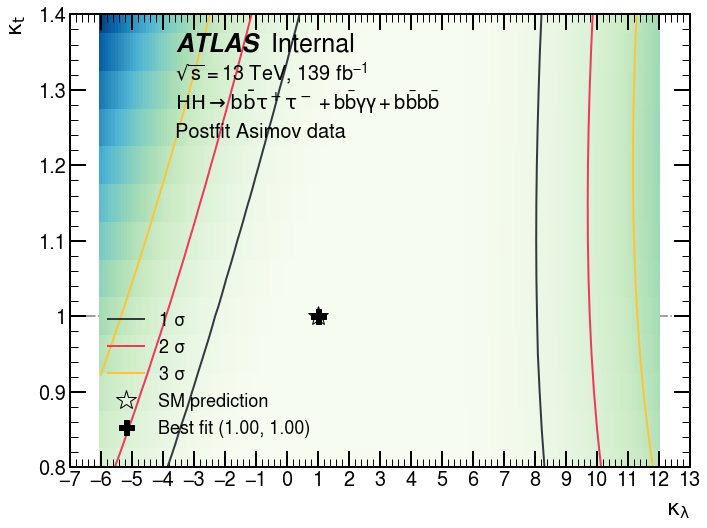

In [177]:
for channel in channels+['combined']:
    for o in obs:
        for study in studies:
            if '1D' in study: continue
            _ = plot_kl_kt(study, o, channel)
            _ = plot_kl_kt(study, o, channel, True)
        


> /afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/submodules/quickstats/quickstats/plots/likelihood_2D_plot.py(75)draw_single_data()
     73         set_trace()
     74 
---> 75         if show_colormesh:
     76             ax.pcolormesh(X, Y, Z, cmap='GnBu', shading='auto')
     77         cp = ax.contour(X, Y, Z, levels=levels, colors=colors, linewidths=2)

ipdb> X
array([[1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ],
       [1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ],
       [1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ]])
ipdb> c


/afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/submodules/quickstats/quickstats/plots/likelihood_2D_plot.py:75: UserWarning: No contour levels were found within the data range.
  if show_colormesh:


Save /afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/output_HHH_20220415//figures/likelihood_scan/likelihood_scan_bbyy_2D_kl_kt_prefit_mesh.pdf


<Figure size 432x288 with 0 Axes>

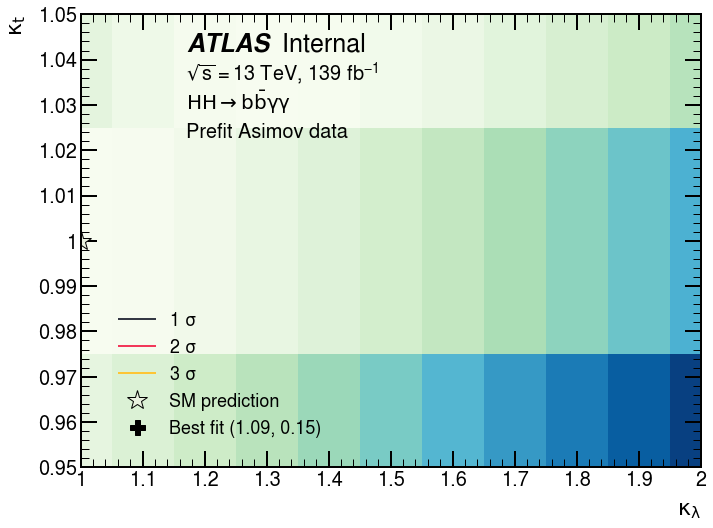

In [176]:
df = plot_kl_kt('2D_kl_kt', 'prefit', 'bbyy', True, ymin=0.95, ymax=1.05, xmin=1, xmax=2)


In [125]:
df

,nll,qmu,klambda,kt
13,531.824185,22.928186,-6.0,1.40
12,531.293702,21.867221,-6.0,1.35
11,530.729490,20.738796,-6.0,1.30
10,530.135164,19.550144,-6.0,1.25
8,528.873352,17.026520,-6.0,1.15
...,...,...,...,...
2343,529.342074,17.963964,12.0,0.90
2342,528.992298,17.264412,12.0,0.85
2341,528.586437,16.452690,12.0,0.80
2346,530.040251,19.360318,12.0,1.05


Save /afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/output_HHH_20220415//figures/likelihood_scan/likelihood_scan_combined_2D_kl_kt_obs_mesh.pdf


<Figure size 432x288 with 0 Axes>

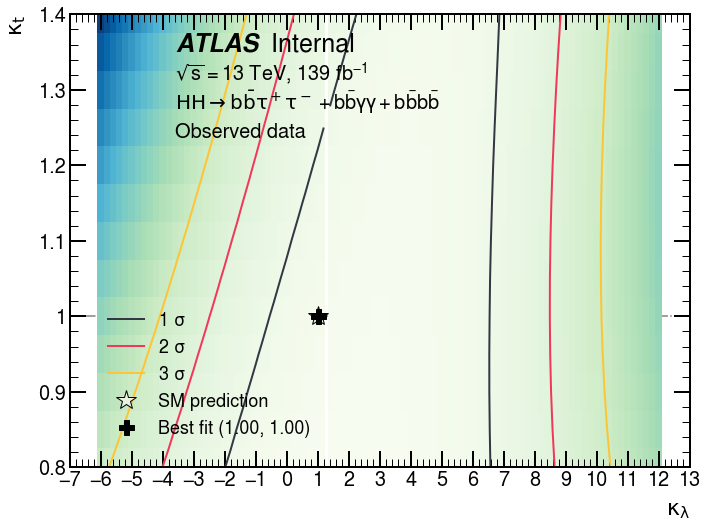

In [241]:
df = plot_kl_kt('2D_kl_kt', 'obs', 'combined', True)


In [ ]:
from glob import glob
for o in ['obs', 'prefit', 'postfit']:
    for channel in channels+['combined']:
        for study in studies:
            json_path = f'{outdir_likelihood}/likelihood_scan/{o}/{channel}/{study}/cache/*json'
            log_path = f'{outdir_likelihood}/likelihood_scan/{o}/{channel}/{study}/cache/*log'
            json_files = glob(json_path)
            json_files = [j.replace('json', 'log') for j in json_files]
            log_files = glob(log_path)
            print(len(json_files)==len(log_files), len(json_files), len(log_files))
            if len(json_files)!=len(log_files):
                print(set(log_files) - set(json_files))
